In [1]:
import os

In [2]:
%pwd

'/Users/rociocuatecontzi/Desktop/programming/electricity-forecast/research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'/Users/rociocuatecontzi/Desktop/programming/electricity-forecast'

In [5]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class PredictionConfig:
    root_dir: Path
    model_path: Path
    prediction_path: Path
    scatterplot_path: Path
    target_column: str
    columns: str

In [6]:
from eForecaster.constants import *
from eForecaster.utils.common import read_yaml, create_directories, save_json

In [7]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    
    def get_prediction_config(self) -> PredictionConfig:
        config = self.config.prediction
        params = self.params.XGRBoost
        schema =  self.schema

        create_directories([config.root_dir])

        model_evaluation_config = PredictionConfig(
            root_dir=config.root_dir,
            model_path = config.model_path,
            prediction_path=config.prediction_path,
            scatterplot_path=config.scatterplot_path,
            target_column = schema.TARGET_COLUMN.name,
            columns = schema.COLUMNS,
        )
        return model_evaluation_config


In [8]:
import os
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt

In [12]:

class Prediction:
    def __init__(self, config: PredictionConfig):
        self.config = config

    
    def get_model(self):
        model = joblib.load(self.config.model_path)
        return model
    
    def create_datetime_df(self, start_date: str, end_date: str):
        start_date = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
        end_date = datetime.strptime(end_date,"%Y-%m-%d %H:%M:%S")
        datetime_df = pd.date_range(start_date, end_date, freq='15min')
        datetime_df = datetime_df.to_frame(index=False, name="datetime")
        return datetime_df

    def create_prediction_df(self, df):
        df['hour'] = df.datetime.dt.hour
        df['dayofweek'] = df.datetime.dt.dayofweek
        df['quarter'] = df.datetime.dt.quarter
        df['month'] = df.datetime.dt.month
        df['year'] = df.datetime.dt.year
        df['dayofyear'] = df.datetime.dt.dayofyear
        df['minute'] = df.datetime.dt.minute
        return df
        
    def get_prediction(self, df):
        model = joblib.load(self.config.model_path)
        df_to_predict = df[[item for item in self.config.columns.keys()]]
        df_predicted = model.predict(df_to_predict)
        return df_predicted

    def get_scatterplot(self, df):
        print(Path(self.config.scatterplot_path))
        ax=sns.scatterplot(data=df, x='datetime', y='prediction')
        plt.title('Predicted electricity consumption over the given period')
        plt.savefig(Path(self.config.scatterplot_path))
        plt.show()
        plt.clf()


[2024-02-09 19:30:55,060: INFO: common: yaml file: config/config.yaml loaded successfully]
[2024-02-09 19:30:55,063: INFO: common: yaml file: params.yaml loaded successfully]
[2024-02-09 19:30:55,066: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-02-09 19:30:55,067: INFO: common: created directory at: artifacts]
[2024-02-09 19:30:55,068: INFO: common: created directory at: artifacts/prediction]
artifacts/prediction/scatterplot.png


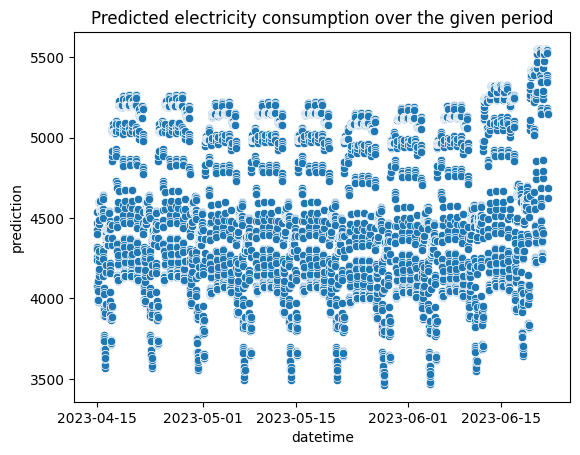

<Figure size 640x480 with 0 Axes>

In [11]:
try:
    config = ConfigurationManager()
    prediction_config = config.get_prediction_config()
    prediction = Prediction(config=prediction_config)
    model = prediction.get_model()
    start_date = "2023-04-15 00:00:00"
    end_date = "2023-06-22 00:15:00"
    datetime_df = prediction.create_datetime_df(start_date, end_date)
    df = prediction.create_prediction_df(datetime_df)
    datetime_df['prediction'] = prediction.get_prediction(df)
    prediction.get_scatterplot(datetime_df)
except Exception as e: 
    raise e